In [54]:
from brian2 import *

start_scope()
prefs.codegen.target = "numpy"
N = 30

In [55]:
# Izhekevich
a = 0.02/ms
b = 0.2/ms
c = -65*mV
d = 5*mV/ms
I2 = 15*mV/ms

eqs_Izh = '''
         dv1/dt = (0.04*v1**2/ms/mV + 5*v1/ms + 140*mV/ms - u + I2) : volt
         du/dt = a*(b*v1-u) : volt/second
      '''  
G1 = NeuronGroup(N, model = eqs_Izh, threshold = 'v1>=-30*mV', reset = 'v1=c; u += d', method = 'euler')
G1.v1 = c
G1.u = b*G1.v1

In [56]:
#HH

C_m = 1*ufarad/cm**2
g_Na = 120*msiemens/cm**2
g_K = 36*msiemens/cm**2
g_L = 0.3*msiemens/cm**2
E_Na = 50*mV
E_K = -77*mV
E_L = -54.4*mV
I_ext = 10*uA/cm**2

eqs_HH = '''
            dv/dt = (I_ext - g_Na*m**3*h*(v-E_Na) - g_K*n**4*(v-E_K) + g_L*(v-E_L))/C_m : volt
            dm/dt = alpha_m*(1-m) - beta_m*m : 1
            dn/dt = alpha_n*(1-n) - beta_n*n : 1
            dh/dt = alpha_h*(1-h) - beta_h*h : 1

            alpha_m = 0.1/mV*(25*mV - v)/(exp((25*mV - v)/(10*mV))-1)/ms : Hz
            beta_m = 4*(exp(-v/(18*mV)))/ms : Hz
            
            alpha_h = 0.07*(exp(-v/(20*mV)))/ms : Hz
            beta_h = 1/(exp((30*mV - v)/(10*mV)) + 1)/ms : Hz

            alpha_n = 0.01/mV*(10*mV - v)/(exp((10*mV - v)/(10*mV))  -1)/ms : Hz
            beta_n = 0.125*(exp(-v/(80*mV)))/ms : Hz
        '''

defaultclock.dt = 0.01*ms
G2 = NeuronGroup(N, model = eqs_HH, method = 'exponential_euler')
G2.v = -65*mV
G2.m = 0.05
G2.h = 0.6
G2.n = 0.32

In [57]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

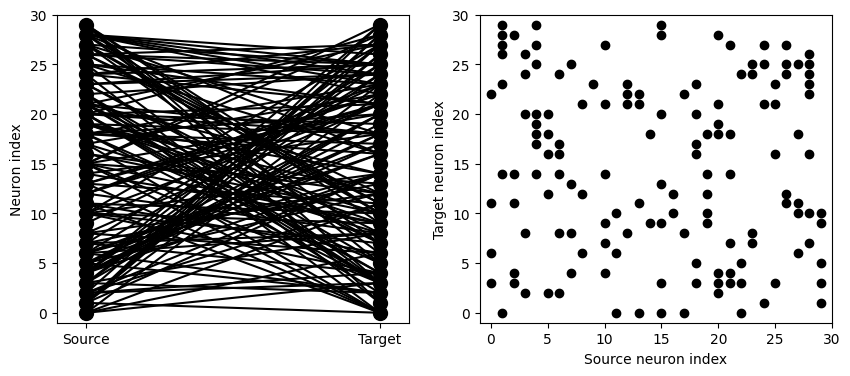

In [58]:
S = Synapses(G1, G2, on_pre = 'v_post += 0.02*volt')
S.connect(condition = 'i!= j', p = 0.2)
visualise_connectivity(S)

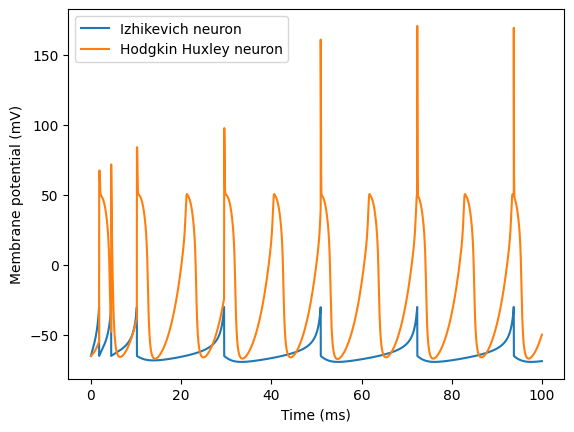

In [59]:
M1 = StateMonitor(G1, 'v1', record=True)
M2 = StateMonitor(G2, 'v', record=True)
run(100*ms)

plot(M1.t/ms, M1.v1[0]/mV, label='Izhikevich neuron')
plot(M2.t/ms, M2.v[0]/mV, label='Hodgkin Huxley neuron')
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()